<b><h2> Предсказание оттока клиентов оператора связи. <a class="tocSkip"> </h2><b>

<b>Цель данной работы</b> - сформировать модель предсказания оттока клиентов для оператора связи, что позволит бизнесу коммуницировать с потенциально отточными клиентами и сохранять их. Заказчиком обозначен целевой уровень качества предсказания на уровне 0.85, по метрике ROC-AUC.

Для достижения поставленных целей, требуется:
- провести исследовательский анализ предоставленных данных
- преобразовать/сформировать признаки для обучения
- подобать модель классификации с наилучшим качеством
- подготовить отчёт для заказчика

## План работы и EDA

### Загрузка сбор датасета

In [1]:
import pandas as pd
import phik
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score
from sklearn.compose import make_column_transformer
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool, cv
import optuna
from optuna.distributions import IntDistribution as intd
from optuna.distributions import FloatDistribution as fl
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 80523

In [3]:
try:
    phone = pd.read_csv('/datasets/phone_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    contract = pd.read_csv('/datasets/contract_new.csv', parse_dates = ['BeginDate'])
except:
    phone=pd.read_csv(r'datasets\phone_new.csv')
    internet = pd.read_csv(r'datasets\internet_new.csv')
    personal = pd.read_csv(r'datasets\personal_new.csv')
    contract = pd.read_csv(r'datasets\contract_new.csv',parse_dates = ['BeginDate'])

In [4]:
contract.columns=contract.columns.str.lower()
internet.columns=internet.columns.str.lower()
personal.columns=personal.columns.str.lower()
phone.columns=phone.columns.str.lower()

In [5]:
#Проверка на наличие полных дубликатов
print(contract.shape)
contract.drop_duplicates()
print(contract.shape)
print(internet.shape)
internet.drop_duplicates()
print(internet.shape)
print(personal.shape)
personal.drop_duplicates()
print(personal.shape)
print(phone.shape)
phone.drop_duplicates()
print(phone.shape)

(7043, 8)
(7043, 8)
(5517, 8)
(5517, 8)
(7043, 5)
(7043, 5)
(6361, 2)
(6361, 2)


In [6]:
# Объединяем данные в 1 dataframe
data = pd.merge(contract, personal, how='left', left_on='customerid',right_on='customerid').merge(internet, 
                                    how='left', left_on='customerid',right_on='customerid').merge(phone, 
                                    how='left', left_on='customerid',right_on='customerid')

In [7]:
# Добавляем таргет и удаляем дату закрытия договора
def target(column):
    if column=='No':
        return 0
    else:
        return 1
data['target']=data['enddate'].apply(target)
data.head()

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,NaN,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


In [8]:
data.describe(include='all')

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,...,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target
count,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043,7043.000000,...,7043,5517,5517,5517,5517,5517,5517,5517,6361,7043.000000
unique,7043,77,67,3,2,4,NaN,6658,2,NaN,...,2,2,2,2,2,2,2,2,2,NaN
top,7590-VHVEG,2014-02-01 00:00:00,No,Month-to-month,Yes,Electronic check,NaN,,Male,NaN,...,No,Fiber optic,No,No,No,No,No,No,No,NaN
freq,1,366,5942,3875,4171,2365,NaN,11,3555,NaN,...,4933,3096,3498,3088,3095,3473,2810,2785,3390,NaN
first,NaN,2013-10-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2020-02-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN,0.162147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.156325
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN,0.368612,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.363189
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
 8   gender            7043 non-null   object        
 9   seniorcitizen     7043 non-null   int64         
 10  partner           7043 non-null   object        
 11  dependents        7043 non-null   object        
 12  internetservice   5517 non-null   object        
 13  onlinesecurity    5517 non-null   object        
 14  onlinebackup      5517 n

In [10]:
print('Доля записей с целевым признаком:',data['target'].mean())

Доля записей с целевым признаком: 0.15632542950447254


## Подготовка данных и обучение модели

### Изменение типов данных

In [11]:
# id клиента назначим индексом
data.set_index('customerid', inplace=True)
data.head()

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target
customerid,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0


In [12]:
# не для всех записей заполнено поле totalcharges. Посмотрим на данныйх клиентов. 
data[data['totalcharges']==' ']

,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target
customerid,,,,,,,,,,,,,,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,NaN,0
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,Male,0,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,NaN,0
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,0
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No,0


У нас данные актуальны на февраль 2020 года. Вивдим, что totalcharges не заполнен для новых клиентов, кто в феврале открыл договор. Клиент ещё ничего не заплатил оператору, поэтому на значение monthlycharges

In [13]:
data.loc[data['totalcharges']==' ','totalcharges'] = data.loc[data['totalcharges']==' ','monthlycharges']

In [14]:
data['totalcharges'] = data['totalcharges'].astype('float64')

In [16]:
data.loc[data['enddate']=='No','enddate'] = '2020-02-01'
data['lt'] = ((pd.to_datetime(data['enddate'])-data['begindate'])/np.timedelta64 ( 1 , 'D')).astype(int)
data.drop(['begindate','enddate'],inplace=True, axis = 1)

Уже в таком виде даные подойдёт для обучения бустинга. Поэтому, далее данные будем преобразовывать в зависимости от рассматриваемой модели.

### Заполнение пропусков

Пропуски у нас появились после объединения данных. Причина пропусков, в том, что часть клиентов использует только интернет либо только телефонную связь. Можно все пропуски заменить на значение "No", но в таком случае, мы потеряем часть информации, т.к. признак, что клиент не использует какой-то тип услуг может быть тоже информативет. Поэтому, введём новое значение 'oth' для всех категориальных признаков с пропусками.

In [17]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        data.loc[data[column].isna(), column] = 'No'

### Исследовательчский анализ.

Посмjтрим, что происходит с оттоком.

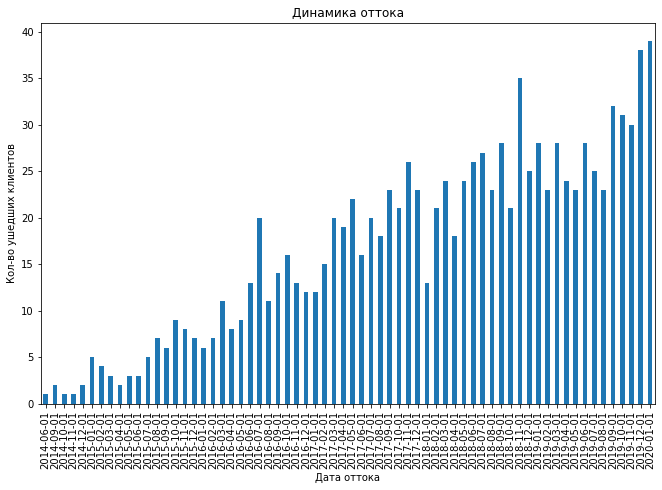

In [18]:
contract[contract['enddate']!='No'].groupby(by = 'enddate')['enddate'].count().plot(kind='bar', figsize=(11, 7))
plt.xlabel('Дата оттока')
plt.ylabel('Кол-во ушедших клиентов')
plt.title('Динамика оттока')
plt.show()

In [19]:
data.head()

,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,gender,seniorcitizen,partner,dependents,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,multiplelines,target,lt
customerid,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Посмотрим на корреляцию признаков и таргета:

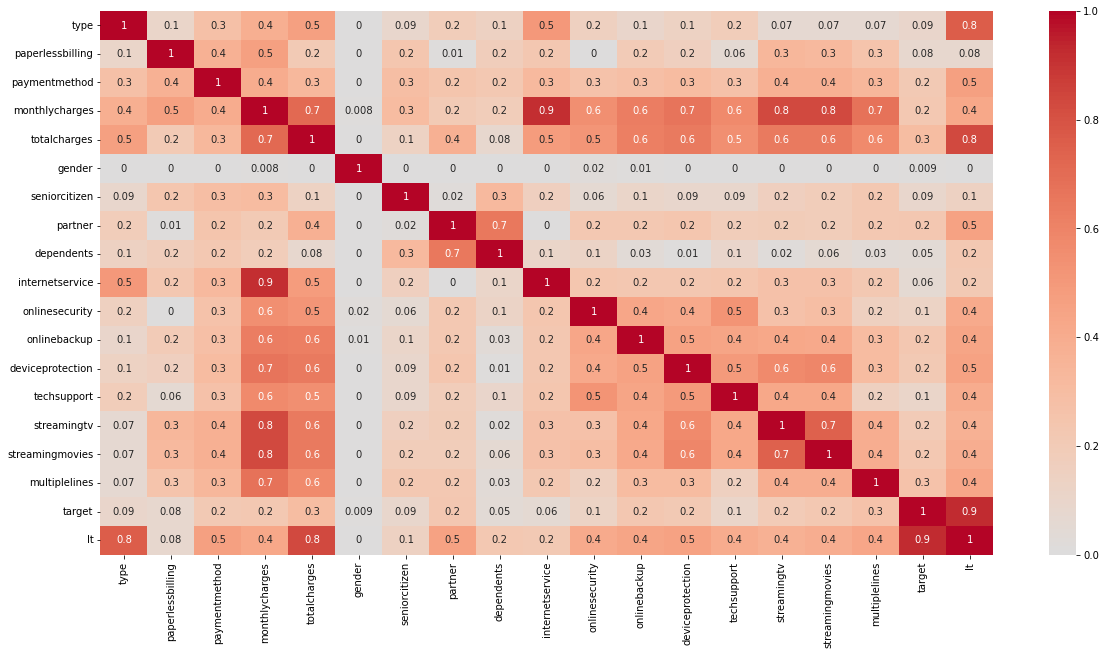

In [20]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data.phik_matrix(interval_cols=['monthlycharges','totalcharges']), cmap='coolwarm', center=0, annot = True, fmt='.1g')
plt.show()

По данной матрице сложно сделать какие-то выводы. Корреляция низкая по всем признакам. Поэтому, посмотрим отдельно признаки.

In [21]:
for_del = ['gender','totalcharges','internetservice']

Сначала посмотрим числовые признаки

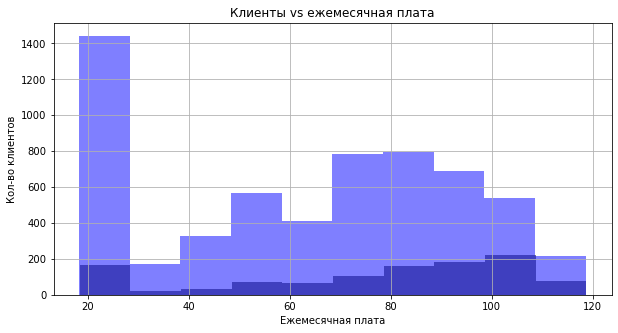

In [22]:
data[data['target']==1]['monthlycharges'].hist(bins=10, figsize=(10,5),alpha=0.5, color='black')
data[data['target']==0]['monthlycharges'].hist(bins=10, figsize=(10,5),alpha=0.5, color='blue')
plt.xlabel("Ежемесячная плата")
plt.ylabel("Кол-во клиентов")
plt.title('Клиенты vs ежемесячная плата')
plt.show()

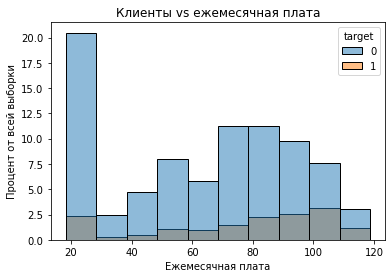

In [23]:
sns.histplot(data = data, x = 'monthlycharges', hue = 'target', stat='percent', common_norm=True, bins = 10)
plt.title('Клиенты vs ежемесячная плата')
plt.xlabel('Ежемесячная плата')
plt.ylabel('Процент от всей выборки')
plt.show()

В отток уходят клиенты, у которых тариф стоит больше чем в среднем по клиентской базе.

In [24]:
data.groupby(by = 'target')['monthlycharges'].mean()

target
0    62.763455
1    75.546004
Name: monthlycharges, dtype: float64

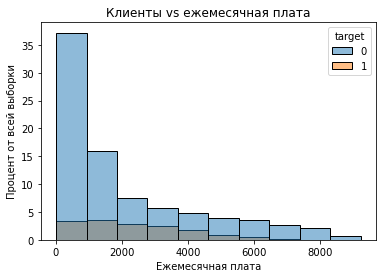

In [25]:
sns.histplot(data = data, x = 'totalcharges', hue = 'target', stat='percent', common_norm=True, bins = 10)
plt.title('Клиенты vs ежемесячная плата')
plt.xlabel('Ежемесячная плата')
plt.ylabel('Процент от всей выборки')
plt.show()

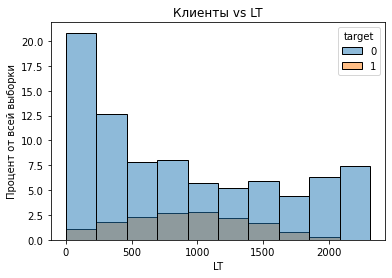

In [26]:
sns.histplot(data = data, x = 'lt', hue = 'target', stat='percent', common_norm=True, bins = 10)
plt.title('Клиенты vs LT')
plt.xlabel('LT')
plt.ylabel('Процент от всей выборки')
plt.show()

Данный график противоречит предыдущему выводу по графику ежемесячной платы. Всё становится понятно, года смотрим на тип клиента по сроку жижни.

Переходим к категориальным признакам. К категориальным, в том числе, отнесём признак "пенсионера" и год начала договора.

In [27]:
cat_features = ['type','paperlessbilling', 'paymentmethod','seniorcitizen','partner','dependents',
                'onlinesecurity','onlinebackup','deviceprotection','techsupport','streamingtv',
                'streamingmovies','multiplelines']
num_features = ['monthlycharges', 'lt']

Какие выводы можно сделать:
- отток от пола не зависит
- больше оттекают клиенты с подключенными услугами стрименга
- больше оттекают клиенты с автоматической оплатой
- больше оттекают клиенты, которые платят раз в год/раз в 2 года
- так же видим, что тарифы оператора снижаются год к году. Может меняться наполнение услугами по тарифам. Клиенты предпочитают тарифы с меньшим кол-вом доп. услуг и более низкой абонентской платой

Переходим к моделированию. Формируем выборки для обучения и теста.

In [34]:
#удалим, что ранее планировали
data = data.drop(for_del, axis=1)

In [35]:
target = data['target']
features = data.drop('target', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, random_state=RANDOM_STATE)

In [36]:
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5282, 15)
(5282,)
(1761, 15)
(1761,)


### Логистическая регрессия

In [37]:
log_reg = LogisticRegression(random_state=RANDOM_STATE)

In [38]:
# категориальные признаки кодируем
transformer = OneHotEncoder(drop='first', handle_unknown='error')
# числовые стандартизируем
scale = StandardScaler()
make_column_log_reg = make_column_transformer((transformer, cat_features),(scale, num_features))

In [39]:
pipeline_log_reg = make_pipeline(make_column_log_reg, log_reg)
pipeline_log_reg .get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'logisticregression', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__standardscaler', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'columntransformer__standardscaler__copy', 'columntransformer__standardscaler__with_mean', 'columntransformer__standardscaler__with_std', 'logisticregression__C', 'logisticregression__class_weight', 'logisticregression__dual', 'logisticregression__fit_intercept', 'logisticregression__intercept_scaling', 'logisticregression__l1_ratio', 'logisticregression__max_iter', 'logisticregression__multi_class', 'lo

In [40]:
parameters_grid_log_reg = {
    'logisticregression__C': [ 0.01, 0.1, 1, 5, 10, 20, 30, 40],
    'logisticregression__penalty' : ['l1','l2','elasticnet'],
    'logisticregression__solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [41]:
%%time
grid_log_reg = GridSearchCV(pipeline_log_reg, parameters_grid_log_reg, scoring = 'roc_auc', cv = 4, n_jobs=-1)
grid_log_reg.fit(features_train, target_train)
print('best_params:',grid_log_reg.best_params_)
print('ROC_AUC:',grid_log_reg.best_score_)

best_params: {'logisticregression__C': 1, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}
ROC_AUC: 0.7530177923735278
Wall time: 3.64 s


Выводы по логистической регресси:
- на обучающем наборе данных требуемое качество достигается
- используем полный перебор параметров, т.к. время вычисления не превышает 10 секунд

### Random Forest

In [42]:
RFC = RandomForestClassifier(random_state=RANDOM_STATE)

In [43]:
transformer = OneHotEncoder(drop='first', handle_unknown='error')
scale = StandardScaler()
make_column_rfc = make_column_transformer((transformer, cat_features), remainder='passthrough')
pipeline_rfc = make_pipeline(make_column_rfc, RFC)
pipeline_rfc.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'columntransformer', 'randomforestclassifier', 'columntransformer__n_jobs', 'columntransformer__remainder', 'columntransformer__sparse_threshold', 'columntransformer__transformer_weights', 'columntransformer__transformers', 'columntransformer__verbose', 'columntransformer__onehotencoder', 'columntransformer__onehotencoder__categories', 'columntransformer__onehotencoder__drop', 'columntransformer__onehotencoder__dtype', 'columntransformer__onehotencoder__handle_unknown', 'columntransformer__onehotencoder__sparse', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_impurity_split', 'randomforestclassifier__min_samples

In [44]:
parameters_grid_rfc = {
    'randomforestclassifier__max_depth': [None] + [i for i in range(2, 11)],
    'randomforestclassifier__n_estimators': [150, 200, 250],
    'randomforestclassifier__criterion': ['gini','entropy','log_loss']
}

In [45]:
%%time
grid_rfc = GridSearchCV(pipeline_rfc, parameters_grid_rfc, scoring = 'roc_auc', cv = 4, n_jobs=-1)
grid_rfc.fit(features_train, target_train)
print('best_params:',grid_rfc.best_params_)
print('ROC_AUC:',grid_rfc.best_score_)

best_params: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__n_estimators': 150}
ROC_AUC: 0.8305293884097917
Wall time: 19.7 s


Выводы по модели Random Forest:
- уже лучше 0,83

### Градиентный бустинг

Направшивается использование catboost, т.к. у нас много категориальных признаков. Так же посмотрим на LightGBM. Для второго нужно поменять тип категориальных переменных.

In [46]:
features_train_lgbm = features_train.copy()
features_test_lgbm = features_test.copy()
for c in cat_features:
    features_train_lgbm[c] = features_train_lgbm[c].astype('category')
    features_test_lgbm[c] = features_test_lgbm[c].astype('category')

<b>LightGBM</b>

In [47]:
gbm = LGBMClassifier(random_state = RANDOM_STATE)

In [48]:
parameters = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': [2, 3, 4],
              'n_estimators': [50, 60, 70, 80],
              'subsample': [0.7, 0.8, 0.9],
              'colsample_bytree': [ 0.9, 1],
              'num_leaves': [80, 90, 100]
             }

In [49]:
%%time
grid_lgbm = GridSearchCV(gbm, param_grid=parameters, scoring='roc_auc', cv=4, n_jobs=2)
grid_lgbm.fit(features_train_lgbm, target_train)
print('best_params:',grid_lgbm.best_params_)
print('ROC_AUC:',grid_lgbm.best_score_)

best_params: {'colsample_bytree': 1, 'learning_rate': 0.4, 'max_depth': 4, 'n_estimators': 80, 'num_leaves': 80, 'subsample': 0.7}
ROC_AUC: 0.8878001347514267
Wall time: 2min 14s


Попробуем подобрать гиперпараметры с помощью библиотеки optuna.

In [50]:
parameters = { 
    'n_estimators': intd(10, 2000),
    'num_leaves': intd(10, 100),
    'reg_alpha': fl(1e-5, 1e0),
    'reg_lambda':  fl(1e-3, 1e0),
    'colsample_bytree': fl(0.5, 1e0),
    'subsample': fl(0.4, 1e0),
    'learning_rate': fl(0.01,0.5),
    'max_depth': intd(1,20)
    }

In [51]:
%%time
optuna_lgb = optuna.integration.OptunaSearchCV(gbm,
                                               parameters,
                                               timeout=1800,
                                               scoring= 'roc_auc', 
                                               cv=4,
                                               random_state = RANDOM_STATE
                                              )


optuna_lgb.fit(features_train_lgbm, target_train)
print('best_params:',optuna_lgb.best_params_)
print('ROC_AUC:',optuna_lgb.best_score_)

[I 2023-05-18 20:47:06,103] A new study created in memory with name: no-name-65daa412-b406-4d65-892d-b3ac8b61969f
[I 2023-05-18 20:47:09,990] Trial 0 finished with value: 0.869419937854502 and parameters: {'n_estimators': 1311, 'num_leaves': 92, 'reg_alpha': 0.8456595665535572, 'reg_lambda': 0.46268581706131934, 'colsample_bytree': 0.9176143423535181, 'subsample': 0.4027428540681955, 'learning_rate': 0.046884128178941005, 'max_depth': 20}. Best is trial 0 with value: 0.869419937854502.
[I 2023-05-18 20:47:12,922] Trial 1 finished with value: 0.8972346603209864 and parameters: {'n_estimators': 1626, 'num_leaves': 20, 'reg_alpha': 0.1760431341970885, 'reg_lambda': 0.9388936545315266, 'colsample_bytree': 0.6282532737829509, 'subsample': 0.702342728815607, 'learning_rate': 0.03776966165427789, 'max_depth': 7}. Best is trial 1 with value: 0.8972346603209864.
[I 2023-05-18 20:47:13,066] Trial 2 finished with value: 0.8592756773353628 and parameters: {'n_estimators': 56, 'num_leaves': 90, 're

best_params: {'n_estimators': 1459, 'num_leaves': 54, 'reg_alpha': 0.007341572725069944, 'reg_lambda': 0.041557169495244795, 'colsample_bytree': 0.7525980101172007, 'subsample': 0.9969227795115478, 'learning_rate': 0.1748496154739869, 'max_depth': 2}
ROC_AUC: 0.9122573660113578
Wall time: 17.7 s


С optuna удалось подобрать более оптимальные параметры. В сравнении с поиском по сетке качество на обучающей выборке немного выросло.

<b>CatBoost</b>

In [52]:
# объекn для передачи данных в catboost
train_pool = Pool(features_train, target_train, cat_features=cat_features)

In [53]:
def objective(trial):

    global train_pool

    params = {
        'n_estimators': trial.suggest_int("n_estimators", 10, 1000),
        'max_depth': trial.suggest_int("max_depth", 1, 4),
        'subsample': trial.suggest_float("subsample", 0.5, 1.0),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-2, 10),
        'random_strength': trial.suggest_float("random_strength", 0.9, 1.4),
        'learning_rate': trial.suggest_float("eta", 1e-2, 3e-1, log=True),
        'min_data_in_leaf': trial.suggest_int("min_data_in_leaf", 1, 5),
        'grow_policy': trial.suggest_categorical('grow_policy', ['Lossguide']),
        'random_state': trial.suggest_categorical('random_state', [RANDOM_STATE]),
        "eval_metric": trial.suggest_categorical('eval_metric', ['AUC']),
        'loss_function': trial.suggest_categorical('loss_function', ['CrossEntropy']),
        'logging_level': trial.suggest_categorical('logging_level', ['Silent']),
        }
    #объект для оценки на кросс-валидации
    scores = cv(train_pool, params, fold_count=4)

    return scores['test-AUC-mean'].values[-1]

In [54]:
%%time
optuna.logging.set_verbosity(optuna.logging.WARNING)
# создание задачи оптимизации
study = optuna.create_study(direction='maximize')
# запуск оптимизации по параметрам
study.optimize(objective, n_trials=1e6, timeout=200)

Wall time: 4min 10s


In [55]:
print("Количество запусков: {}".format(len(study.trials)))

print("Лучший результат:")
trial = study.best_trial
print("  ROC AUC: {}".format(trial.value))

trial = study.best_trial
parameters = trial.params
print('Оптимальные параметры:', parameters)


Количество запусков: 6
Лучший результат:
  ROC AUC: 0.9138571932851061
Оптимальные параметры: {'n_estimators': 846, 'max_depth': 4, 'subsample': 0.659818062058289, 'l2_leaf_reg': 4.804197019893747, 'random_strength': 1.2825311803188375, 'eta': 0.1455805463331387, 'min_data_in_leaf': 5, 'grow_policy': 'Lossguide', 'random_state': 80523, 'eval_metric': 'AUC', 'loss_function': 'CrossEntropy', 'logging_level': 'Silent'}


Выводы по моделям градиентного бустинга:
- качество получили выше чем у RF или LogReg
- оба бустинга дали сравнимое качество, но LightGBM обучается в разы быстрее

In [56]:
pd.DataFrame({'model': ['LogReg', 'RendomForest', 'LightGBM', 'CatBoost'], 
              'ROC-AUC': [grid_log_reg.best_score_, grid_rfc.best_score_, optuna_lgb.best_score_, trial.value]})

,model,ROC-AUC
0,LogReg,0.753018
1,RendomForest,0.830529
2,LightGBM,0.912257
3,CatBoost,0.913857


<b>Выводы по разделу обучения моделей:</b>
- для тестрирования и представления заказчику выбираем модель LightGBM. 

In [57]:
print('Качество ROC-AUC выбранной модели на тестовой выборке: ',roc_auc_score(target_test, optuna_lgb.
                                                                      predict_proba(features_test_lgbm)[:, 1]))
print('Точность выбранной модели на тестовой выборке: ',accuracy_score(target_test, optuna_lgb.
                                                                      predict(features_test_lgbm)))

Качество ROC-AUC выбранной модели на тестовой выборке:  0.926448930605297
Точность выбранной модели на тестовой выборке:  0.9415105053946621


In [58]:
print(classification_report(target_test, optuna_lgb.predict(features_test_lgbm)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1478
           1       0.92      0.70      0.79       283

    accuracy                           0.94      1761
   macro avg       0.93      0.84      0.88      1761
weighted avg       0.94      0.94      0.94      1761



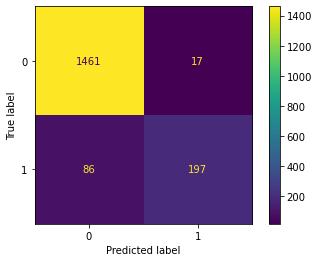

In [59]:
# Матрица ошибок
y_pred = optuna_lgb.predict(features_test_lgbm)
cm = confusion_matrix(target_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

Высокая точность модели, говорит о том, что мы только 8% клиентам предложим скидки, хотя они и не собирались уходить, а полнота, говорит о том, что толкьо 70% от всех потенциально отточных клиентов, модель смогла определить.

In [60]:
f_imp = pd.Series(index = optuna_lgb.best_estimator_.feature_name_,
                  data = optuna_lgb.best_estimator_.feature_importances_,
                  name = 'feature_importances')

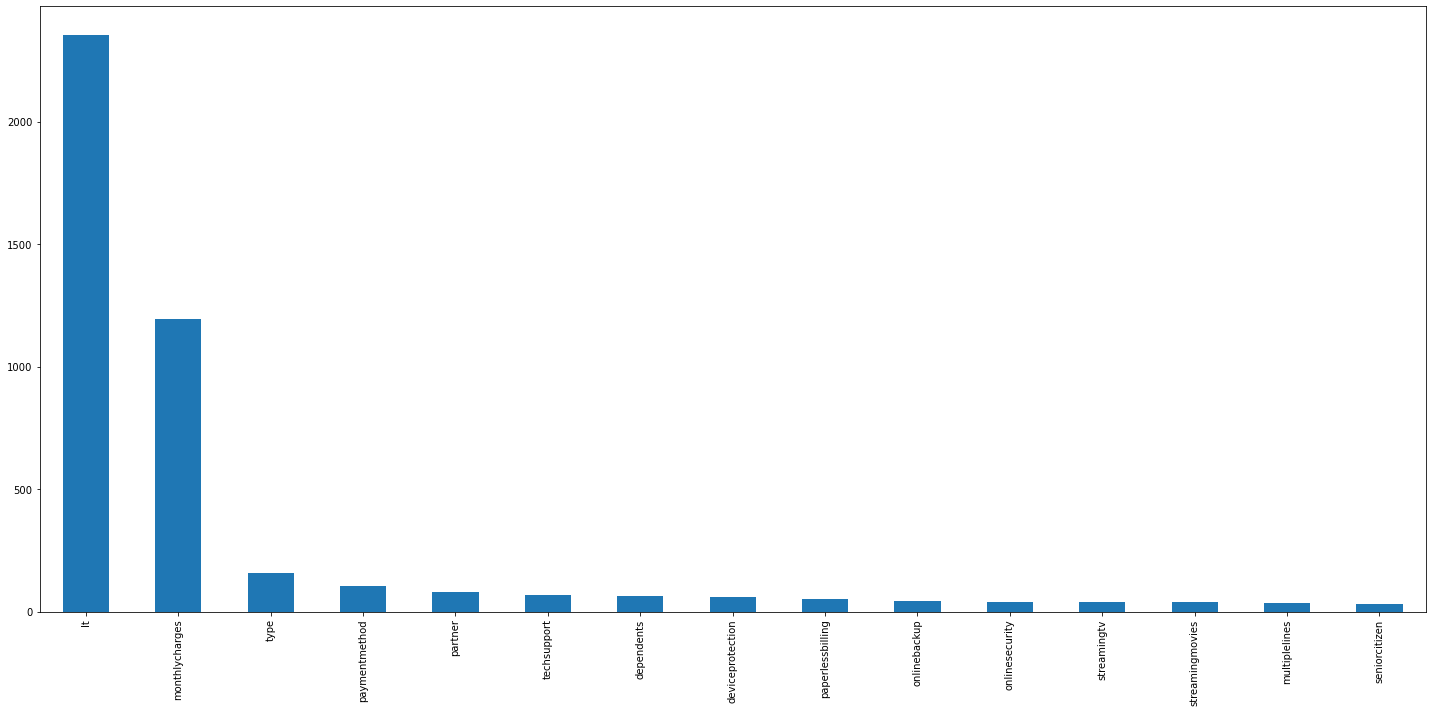

In [61]:
fig, ax = plt.subplots(figsize=(20,10))
f_imp.sort_values(ascending = False).plot.bar(ax=ax)
fig.tight_layout()

Возьмём 2 набора признаков и попробуем обучить бустинг на данных признаках

In [62]:
feature_for_train_lower = f_imp[f_imp>=50].index

In [63]:
feature_for_train_min = f_imp[f_imp>=100].index

In [64]:
features_train_lgbm_lower = features_train_lgbm[feature_for_train_lower.to_list()]
features_test_lgbm_lower = features_test_lgbm[feature_for_train_lower.to_list()]

features_train_lgbm_min = features_train_lgbm[feature_for_train_min.to_list()]
features_test_lgbm_min = features_test_lgbm[feature_for_train_min.to_list()]

Модель формируем по ранее подобранным параметрам

In [65]:
gbm_opt_par = LGBMClassifier(random_state = RANDOM_STATE, n_estimators = 1459, num_leaves = 54, reg_alpha = 0.007341572725069944,
                          reg_lambda = 0.041557169495244795, colsample_bytree = 0.7525980101172007, subsample = 0.9969227795115478,
                          learning_rate = 0.1748496154739869, max_depth = 2)
gbm_opt_min = LGBMClassifier(random_state = RANDOM_STATE, n_estimators = 1459, num_leaves = 54, reg_alpha = 0.007341572725069944,
                          reg_lambda = 0.041557169495244795, colsample_bytree = 0.7525980101172007, subsample = 0.9969227795115478,
                          learning_rate = 0.1748496154739869, max_depth = 2)

In [66]:
gbm_opt_par.fit(features_train_lgbm_lower, target_train)
print('ROC-AUC при обучении по top 9 признакам: ', roc_auc_score(target_test, gbm_opt_par.
                                                              predict_proba(features_test_lgbm_lower)[:, 1]))

ROC-AUC при обучении по top 9 признакам:  0.9239314420690743


In [67]:
gbm_opt_min.fit(features_train_lgbm_min, target_train)
print('ROC-AUC при обучении по top 4 признакам: ', roc_auc_score(target_test, gbm_opt_min.
                                                              predict_proba(features_test_lgbm_min)[:, 1]))

ROC-AUC при обучении по top 4 признакам:  0.9220116478671876


<b>Общие выводы по разделу:</b>
- В рамках данного блока мы изучили взаимосвязи признаков
- Сгенерировали новые признаки/удалили скоррелированные и признаки дат
- Построили 3 вида моделей с подбором параметров на кросс валидации
- Качество финальной модлеи проверили на тестовой выборке и изучили матрицу ошибок.

Выводы по обученной моделе:
- Старые клиенты платят больше в виду дополнительных услуг, о чем говорит динамика стоимости подключения новых клиентов по годам и доля оттока в разрезе опций. В таком ключе, предложение скидки или отключение ненужных опций позволит сохранить клиента.
- Для достижения заявленного качества, достаточно 4 признаков. Качестов снижается на 0,003 по сравнению с обучением на полном наборе признаков. 
- Стоимость тарифа - это некоторый результирующий признак по опциям, поэтому исключение большого кол-ва признаков мало повлияло на качество модели.

## Отчёт

<b>Важным аспектом для построение модели являются признаки.</b>

1. Был сформирован новый признак "Срок жизни договора", который расчитывается, как разница между датой начала действви догвора и последней известной датой

2. При построении модели не учитывались:
    - признак "пола" клиента, т.к. этот признак оказался неважным
    - "суммарный объём средств потраченных клиентогм" и "тип интернет соединения" в виду их сильной скоррелированности с другими признаками, что могло негативно отразиться на качестве
    - были исключены даты, для избежания "утечки таргета". 

3. Итоговый список признаков, используемый в модели:

    - lt - длить договора в днях
    - monthlycharges - ежемесячная плата
    - paymentmethod - способ оплаты
    - type - тип оплаты
    - -----
    - partner - наличие супруги/мужа
    - paperlessbilling - тип платёжного документа
    - seniorcitizen - признак пенсионера
    - dependents - наличие иждивенцев
    - onlinesecurity - антивируса
    - onlinebackup - резервное копирование
    - deviceprotection - антивируса
    - techsupport - тех. поддержка
    - streamingtv - онлайн ТВ
    - multiplelines - параллельные линии для телефонной связи
    - streamingmovies - онлайн - видео

<b>Матрица взаимосвязи признаков и целевого значения:</b>

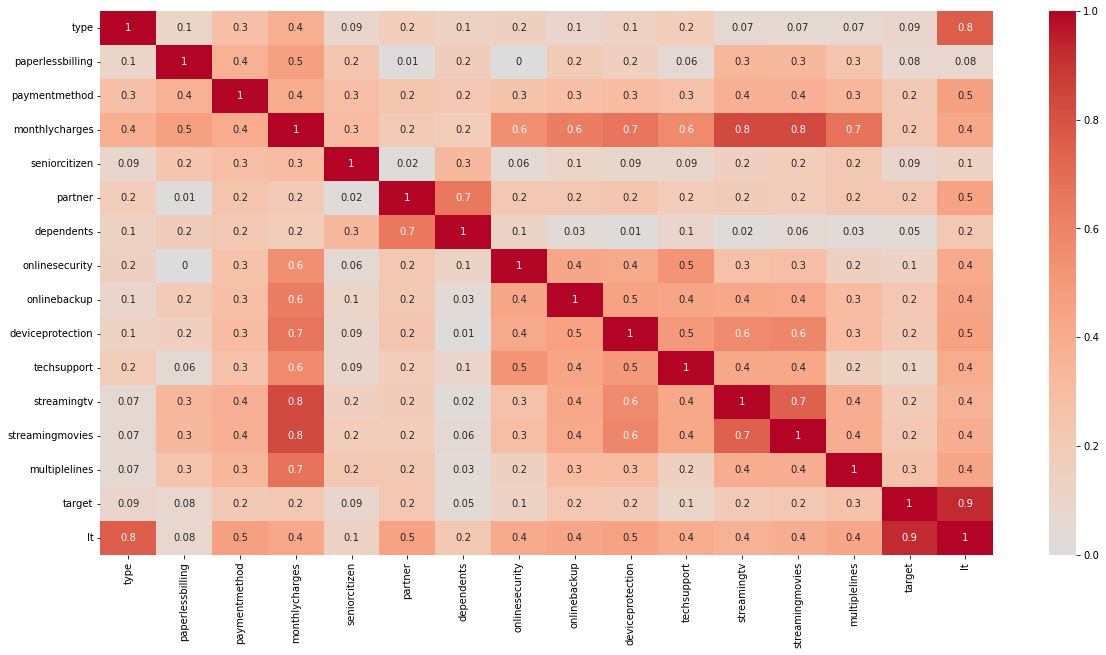

In [70]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(data.phik_matrix(interval_cols=['monthlycharges','totalcharges']), cmap='coolwarm', center=0, annot = True, fmt='.1g')
plt.title('Матрица корреляций')
plt.show()

<b>Результаты обучения модели.</b>

Для каждой расмотренной модели признак обрабытвались по разному:
- OHE для категориальных признаков.
- нормирование для числовых признаков. Перевод числовых значений к диапазону от -1 до 1

In [89]:
print('Виды обученных моделей, качество на кросс-валидации и типы преодработки данных:')
pd.DataFrame({'model': ['LogReg', 'RendomForest', 'LightGBM', 'CatBoost'], 
              'ROC-AUC': [grid_log_reg.best_score_, grid_rfc.best_score_, optuna_lgb.best_score_, trial.value],
             'Обработка признаков':['OHE и нормализация', 'OHE', 'Nan','Nan']
             })

Виды обученных моделей, качество на кросс-валидации и типы преодработки данных:


,model,ROC-AUC,Обработка признаков
0,LogReg,0.753018,OHE и нормализация
1,RendomForest,0.830529,OHE
2,LightGBM,0.912257,Nan
3,CatBoost,0.919100,Nan


Для финального тестирования была выбрана модель градинтного бустинга <b>LightGBM</b> с следющими параметрами:

In [86]:
print('Параметры модели:',optuna_lgb.best_params_)
print('ROC_AUC:',optuna_lgb.best_score_)

Параметры модели: {'n_estimators': 1459, 'num_leaves': 54, 'reg_alpha': 0.007341572725069944, 'reg_lambda': 0.041557169495244795, 'colsample_bytree': 0.7525980101172007, 'subsample': 0.9969227795115478, 'learning_rate': 0.1748496154739869, 'max_depth': 2}
ROC_AUC: 0.9122573660113578


In [87]:
print('Качество ROC-AUC выбранной модели на тестовой выборке: ',roc_auc_score(target_test, optuna_lgb.
                                                                      predict_proba(features_test_lgbm)[:, 1]))
print('Точность выбранной модели на тестовой выборке: ',accuracy_score(target_test, optuna_lgb.
                                                                      predict(features_test_lgbm)))

Качество ROC-AUC выбранной модели на тестовой выборке:  0.926448930605297
Точность выбранной модели на тестовой выборке:  0.9415105053946621


Матрица ошибок:


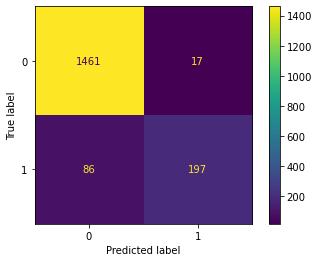

In [88]:
print('Матрица ошибок:')
y_pred = optuna_lgb.predict(features_test_lgbm)
cm = confusion_matrix(target_test, y_pred)

cm_display = ConfusionMatrixDisplay(cm).plot()

- только 8% клиентам предложим скидки, хотя они и не собирались уходить
- модель находит 70% от всех потенциоально отточных клиентов

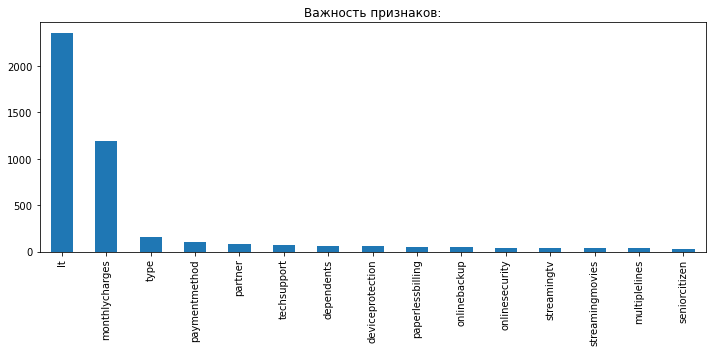

In [92]:
fig, ax = plt.subplots(figsize=(10,5))
f_imp.sort_values(ascending = False).plot.bar(ax=ax)
plt.title('Важность признаков:')
plt.xlabel('Признак')
plt.yalbel('Важность')
fig.tight_layout()

Самыми важными признаками для прогнозирования оттока, являются:
- lt - длить договора в днях
- monthlycharges - ежемесячная плата
- type - тип оплаты
- paymentmethod - способ оплаты

При исключении прочих признаков предсказательная способность модели, практически не меняется.